In [13]:
import numpy as np
np.random.seed(1337) 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, Normalizer
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, LeakyReLU, Flatten, Dropout
from keras.callbacks import History, ModelCheckpoint
from keras import backend as K
import keras
import glob
import os

In [14]:
# Load the data points
os.chdir('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/clusters/')

data_points = []

with open('/Users/dimitrygrebenyuk/Yandex.Disk.localized/Working/PDF/Refinements/PDF-Cluster-Prediction/clusters/labels.txt', 'w') as labels:
    files = glob.glob('*.dat')
    for f in files:
        #file_path = f"pdf_data/dataset_{i}.dat"
        df = pd.read_csv(f, usecols=[1], skiprows=1, header=None, delim_whitespace=True, skipfooter=0, engine='python')
        data_points.append(df.values.ravel())
        labels.write(f[0])
        labels.write('\n')

data_points = np.array(data_points)

In [15]:
# Load the labels
labels = pd.read_csv("labels.txt", header=None)
labels = labels.values.ravel()  # convert the labels to a 1D array

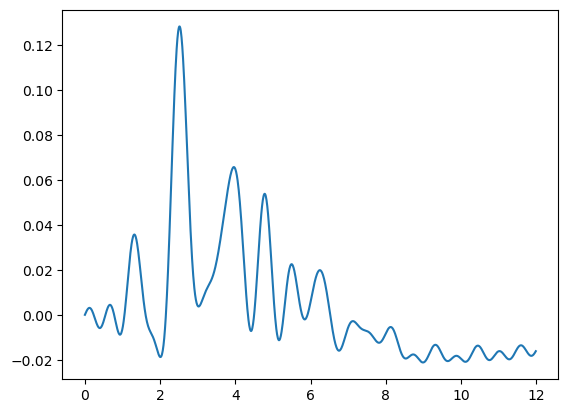

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
# Preprocessing
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler =MaxAbsScaler()
#data_points = scaler.fit_transform(data_points)
normalize = Normalizer()
data_points = normalize.fit_transform(data_points)
fig, ax = plt.subplots()
ax.plot(np.arange(len(data_points[56,:]))/100, data_points[56,:])

In [17]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_points, labels, test_size=0.1, random_state=42)

In [18]:
# Best so far; val accuracy 0.9

model = Sequential()
# Add the convolutional layers
model.add(Conv1D(filters=256, kernel_size=32, activation='relu', input_shape=(1200,1))) # 256, 32
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Conv1D(filters=64, kernel_size=32, activation='relu')) # 64, 32
model.add(MaxPooling1D(pool_size=2)) # 2
model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) # 32, 3
model.add(MaxPooling1D(pool_size=2)) # 2

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(units=64, activation='relu')) # 64
model.add(Dense(units=12, activation='softmax')) # 12

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # adam
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1169, 256)         8448      
                                                                 
 batch_normalization_1 (Batc  (None, 1169, 256)        1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 584, 256)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 553, 64)           524352    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 276, 64)          0         
 1D)                                                             
                                                      

In [19]:
# Train the model
num_epochs = 200

checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

seqModel = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 2.4135 - accuracy: 0.2333
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to best_model.hdf5
3/3 [==============================] - 2s 384ms/step - loss: 2.4135 - accuracy: 0.2333 - val_loss: 2.4511 - val_accuracy: 0.3000
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 1.8846 - accuracy: 0.3222
Epoch 2: val_accuracy improved from 0.30000 to 0.40000, saving model to best_model.hdf5
3/3 [==============================] - 1s 340ms/step - loss: 1.8846 - accuracy: 0.3222 - val_loss: 2.4013 - val_accuracy: 0.4000
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 1.4616 - accuracy: 0.4889
Epoch 3: val_accuracy did not improve from 0.40000
3/3 [==============================] - 1s 304ms/step - loss: 1.4616 - accuracy: 0.4889 - val_loss: 2.2792 - val_accuracy: 0.4000
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 1.1213 - accuracy: 0.6222
Epoch 4: val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


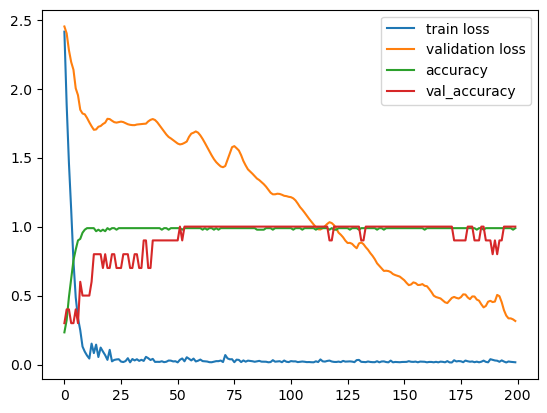

In [20]:
print(seqModel.history.keys())
xc         = range(num_epochs)

plt.plot(xc, seqModel.history['loss'], label='train loss')
plt.plot(xc, seqModel.history['val_loss'], label='validation loss')
plt.plot(xc, seqModel.history['accuracy'], label='accuracy')
plt.plot(xc, seqModel.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [21]:
load_model = keras.models.load_model('best_model.hdf5')

In [ ]:
# Load the new data points
new_data_points = []
for i in range(1, 11):
    file_path = f"path/to/new_data_{i}.csv"
    df = pd.read_csv(file_path, usecols=[1], skiprows=1, header=None)
    new_data_points.append(df.values.ravel())

new_data_points = np.array(new_data_points)

# Normalize the new data points using the same scaler
new_data_points = normalize.transform(new_data_points)

# Make predictions on the new data points
predictions = load_model.predict(new_data_points)